In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/dataset-emotion-ai-facial-keypoints-detection/kaggle/KeyFacialPoints.csv")
print('Number of rows: {}'.format(len(df)))
df.head().T

Number of rows: 2140


,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [3]:
b_size = 64
epoch = 200
lr = 1e-4

In [4]:
def visualize(images, targets, num_cols = 4, subtitle = False):
    disp = len(images)
    plt.figure(figsize=(20,10))
    
    for i in range(disp):
        image = images[i]
        if torch.is_tensor(images[i]):
            image = image.numpy() 
        image = np.reshape(image, (96,96))  
        target = targets[i]
        plt.subplot(disp//num_cols, num_cols, i+1)
        plt.imshow(image, cmap = "gray")
        columns = list(df.columns)
        for j in range(0, 30, 2):
            plt.scatter(target[j], target[j+1], s=10, marker='.', c='r')
        
        if subtitle:
            if i % 2 == 0:
                plt.title('Original')
            
            else:
                plt.title('Predicted')
    
    plt.show()
    

In [5]:
def horizontal_flip(image, target, p = 0.5):
    if torch.rand(1) < p:
        hflip = transforms.RandomHorizontalFlip(p = 1)
        image = hflip(image)
        for i in range(0, 30, 2):
            target[i] = 96.0 - target[i]
            
    return image, target
    
def vertical_flip(image, target, p = 0.5):
    if torch.rand(1) < p:
        flip = transforms.RandomVerticalFlip(p = 1)
        image = flip(image)
        for i in range(1, 30, 2):
            target[i] = 96.0 - target[i]
            
    return image, target

def color_jitter(image, p = 0.5):
    if torch.rand(1) < p:
        jitter = transforms.ColorJitter(brightness=.5, hue=.3)
        image = jitter(image)
    
    return image

def gaussian_blur(image, p = 0.5):
    if torch.rand(1) < p:
        blurrer = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
        image = blurrer(image)
    
    return image

class ImageDataset(Dataset):
    def __init__(self, df, mode = 'train'):
        
        self.df = df
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df['Image'].iloc[index]
        image = np.asarray(image.split(),dtype=np.float32).reshape(96,96,1)
        target = np.asarray(self.df.iloc[index][0:30].to_numpy(), dtype=np.float32)
        image = torch.from_numpy(image.transpose((2, 0, 1)))
        target = torch.from_numpy(target)
        if self.mode == 'train':
            image, target = self.transform(image, target)
        return image, target
    
    def transform(self, image, target):
        image, target = horizontal_flip(image, target)
        image, target = vertical_flip(image, target)
        #image = color_jitter(image)
        image = gaussian_blur(image)
        
        return image, target

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print('Train dataset size : {} \tTest dataset size: {}'.format(len(train_df),len(test_df)))

train_dataset = ImageDataset(train_df, mode = 'train')
train_loader = DataLoader(train_dataset, batch_size = b_size, shuffle=True)

eval_dataset = ImageDataset(test_df, mode = 'eval')
eval_loader = DataLoader(eval_dataset, batch_size = b_size, shuffle = True)

Train dataset size : 1712 	Test dataset size: 428


Text(0.5, 1.0, 'Vertically Flipped')

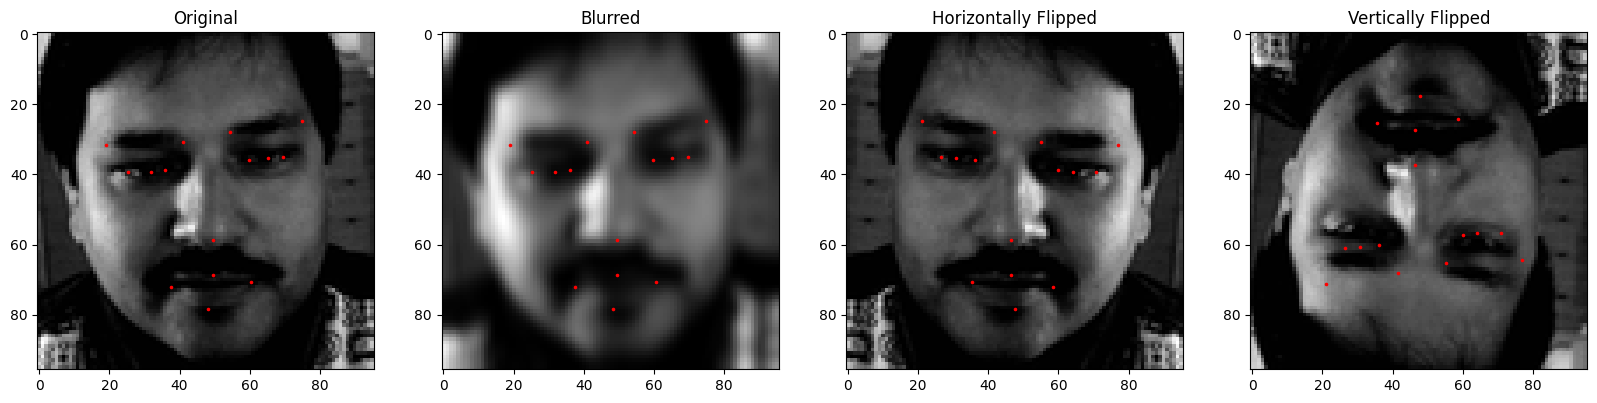

In [7]:
index = 200
image = df['Image'].iloc[index]
image = np.asarray(image.split(),dtype=np.float32).reshape(96,96,1)
target = np.asarray(df.iloc[index][0:30].to_numpy(), dtype=np.float32)
image = torch.from_numpy(image.transpose((2, 0, 1)))
target = torch.from_numpy(target)

plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.imshow(np.reshape(image.numpy(), (96,96)), cmap = "gray")
for j in range(0, 30, 2):
    plt.scatter(target[j], target[j+1], s=10, marker='.', c='r')
plt.title('Original')

image1 = gaussian_blur(image, p=1)
plt.subplot(1, 4, 2)
plt.imshow(np.reshape(image1.numpy(), (96,96)), cmap = "gray")
for j in range(0, 30, 2):
    plt.scatter(target[j], target[j+1], s=10, marker='.', c='r')

plt.title('Blurred')
    

image2, target2 = horizontal_flip(image, target, p=1)
plt.subplot(1, 4, 3)
plt.imshow(np.reshape(image2.numpy(), (96,96)), cmap = "gray")
for j in range(0, 30, 2):
    plt.scatter(target2[j], target2[j+1], s=10, marker='.', c='r')

plt.title('Horizontally Flipped')
image3, target3 = vertical_flip(image, target, p=1)
plt.subplot(1, 4, 4)
plt.imshow(np.reshape(image3.numpy(), (96,96)), cmap = "gray")
for j in range(0, 30, 2):
    plt.scatter(target3[j], target3[j+1], s=10, marker='.', c='r')
    
plt.title('Vertically Flipped')

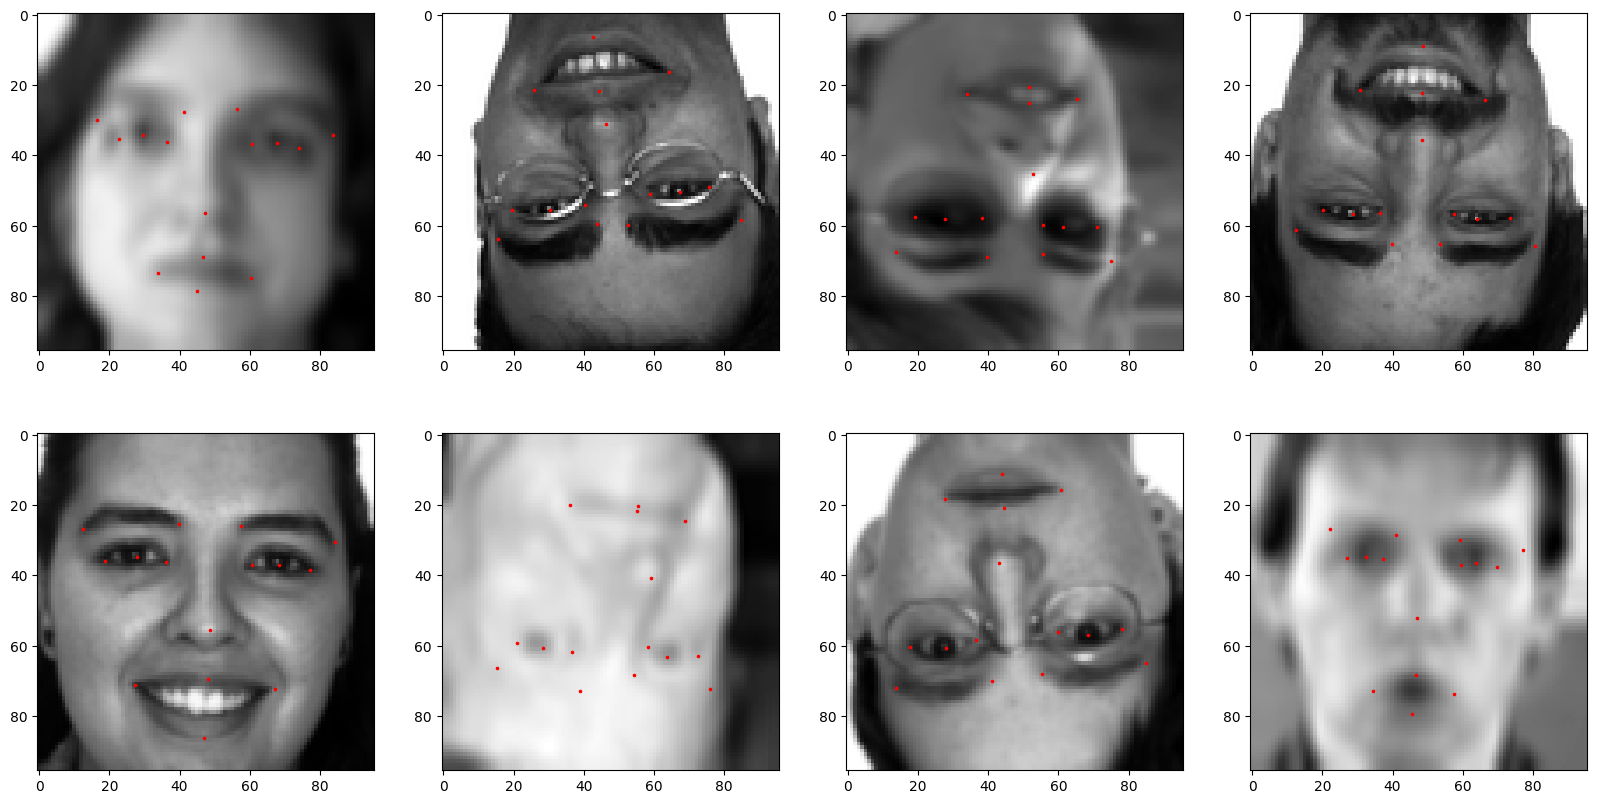

In [8]:
sample_images, sample_targets = next(iter(train_loader))
visualize(sample_images[:8], sample_targets[:8], num_cols = 4)

In [9]:
class Model(nn.Module):
    def __init__(self, num_classes, init_weights = True, batch_norm = True, dropout: float = 0.5):
        super().__init__()
        self.features = self.make_layers(batch_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


    def make_layers(self, batch_norm):
        cfg = [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"]
        layers = []
        in_channels = 1
        for v in cfg:
            if v == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                v = int(v)
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

Epoch: 1 / 200	Training Loss: 727.9758628562645	Eval Loss: 488.76896013532365
Epoch: 11 / 200	Training Loss: 127.26084334762008	Eval Loss: 165.71283176967077
Epoch: 21 / 200	Training Loss: 67.92024132057473	Eval Loss: 58.91503306797573
Epoch: 31 / 200	Training Loss: 48.87584114074707	Eval Loss: 103.79672077723912
Epoch: 41 / 200	Training Loss: 34.51368444937247	Eval Loss: 83.36421149117606
Epoch: 51 / 200	Training Loss: 30.264423864859122	Eval Loss: 53.6832526070731
Epoch: 61 / 200	Training Loss: 30.46255874633789	Eval Loss: 51.752088274274556
Epoch: 71 / 200	Training Loss: 26.08357952259205	Eval Loss: 66.7436032976423
Epoch: 81 / 200	Training Loss: 22.401103055035627	Eval Loss: 60.96489334106445
Epoch: 91 / 200	Training Loss: 22.91365005351879	Eval Loss: 64.58409336635044
Epoch: 101 / 200	Training Loss: 22.14005328990795	Eval Loss: 61.54850823538644
Epoch: 111 / 200	Training Loss: 22.15060841595685	Eval Loss: 58.35246549333845
Epoch: 121 / 200	Training Loss: 19.907446967230904	Eval Lo

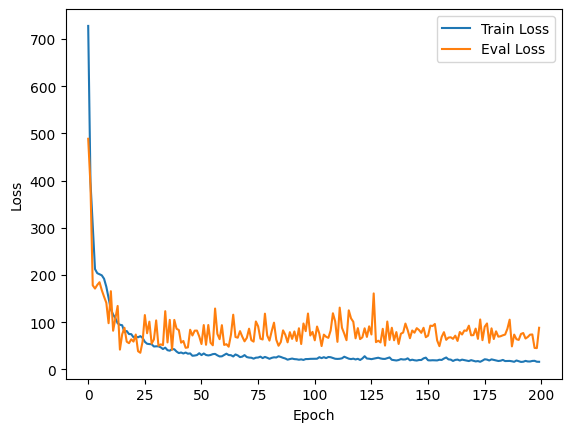

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model(num_classes = 30)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.MSELoss()

def train_one_epoch():
    train_loss = 0.
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_loss += loss.item()
    
    eval_loss = 0.
    model.eval()
    
    for i, data in enumerate(eval_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        eval_loss += loss_fn(outputs, labels).item()
    

    return train_loss / len(train_loader), eval_loss / len(eval_loader)

def train():
    losses_train = []
    losses_eval = []
    for i in range(epoch):
        loss_train, loss_eval = train_one_epoch()
        if i%10 == 0:
            print("Epoch: {} / {}\tTraining Loss: {}\tEval Loss: {}".format(i+1, epoch, loss_train, loss_eval))
        losses_train.append(loss_train)
        losses_eval.append(loss_eval)
    
    plt.figure()
    plt.plot(losses_train, label = 'Train Loss')
    plt.plot(losses_eval, label = 'Eval Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 
train()

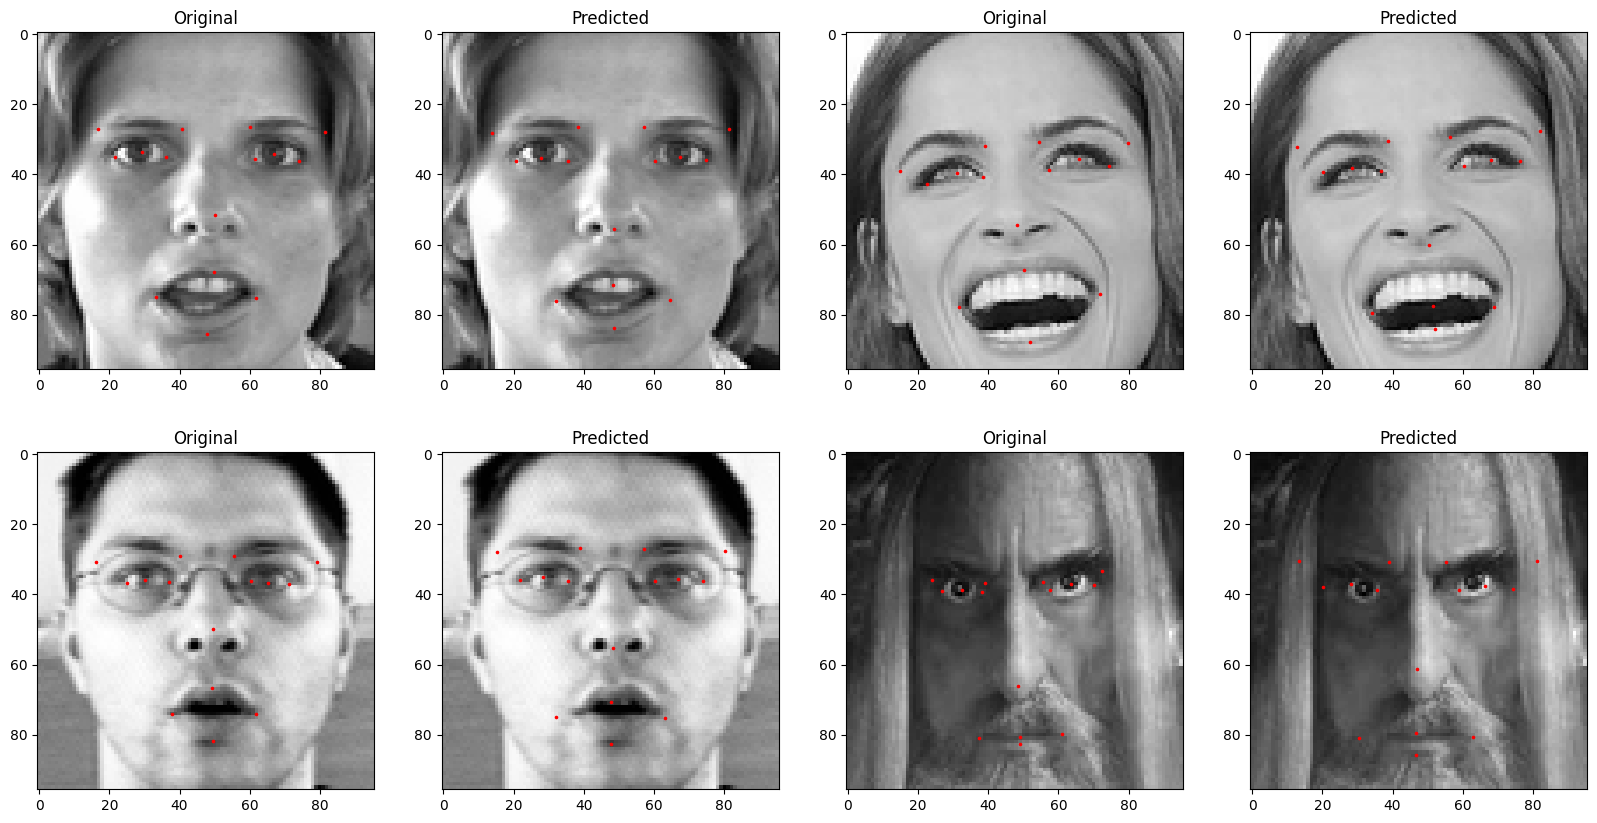

In [11]:
model.eval()
inputs, targets = next(iter(eval_loader))
outputs = model(inputs.to(device)).to('cpu').detach().numpy()

images = []
keypoints = []

for i in range(4):
    images.append(inputs[i])
    images.append(inputs[i])
    keypoints.append(targets[i])
    keypoints.append(outputs[i])
    
visualize(images, keypoints, num_cols = 4, subtitle = True)
    
    